## Model Load

In [1]:
from utils import set_root

from loguru import logger

import numpy as np
import torch

from tqdm import tqdm


from pytorch_lightning import seed_everything
import importlib

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
import pandas as pd

seed_everything(42)
set_root()

Seed set to 42


Current working directory: /home/manni/physioex


In [2]:
%ls

LICENSE*                             lightning_logs/
README.md*                           main.py*
__pycache__/                         mkdocs.yml*
docs/                                models/
embedding_proto15_6612_shhs.npy      multi-source-domain.yaml*
embeddings_mass_ssh_conv3d.npy       my_experiment.yaml*
embeddings_mass_ssh_seqsleepnet.npy  old_models/
example_records/                     physioex/
examples/                            physioex.egg-info/
input_to_check.pt                    requirements.txt*
label_to_check.pt                    setup.py*
labels_mass_ssh_conv3d.npy           teacher_student.py*
labels_mass_ssh_seqsleepnet.npy      teacherstudent.yaml*
labels_proto15_6612_shhs.npy         temp/


In [3]:
#from physioex.data import TimeDistributedModule, SleepEDF, Shhs, SleepMerged
from physioex.data.datamodule import PhysioExDataModule
from physioex.data import get_datasets

from physioex.train.networks import config as networks
from physioex.train.networks.utils.loss import config as losses

from physioex.models import load_pretrained_model

from physioex.train.networks.utils.target_transform import get_mid_label

Seed set to 42
Seed set to 42


In [4]:
# importing
import numpy as np
from loguru import logger
import os
import math

from physioex.train.networks import config

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from loguru import logger

logger.remove()

In [5]:
import seaborn as sns
max = 3
min = -3

def plotTheSpectrogram(spectrogram_tensor, max, min):
    spectrogram_array = spectrogram_tensor.permute(1, 0).numpy()
    
    plt.figure(figsize=(5, 5))
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='viridis',vmin=-3, vmax=4)
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='coolwarm')
    sns.heatmap(spectrogram_array, cmap='coolwarm', cbar=True, vmax=max, vmin=min)
            
    #plt.colorbar(format='%+2.0f')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plotSpectrogram(ax, spectrogram_tensor, title, max, min, denorm=None, cut = None):
    if (denorm is not None):
        mean, std = denorm
        spectrogram_tensor = spectrogram_tensor * std + mean
        spectrogram_tensor = torch.tensor(spectrogram_tensor, dtype=torch.double)
        spectrogram_tensor = 10**(spectrogram_tensor/20)
        cmap='Blues'
    else:
        cmap='coolwarm'

    if cut is not None:
        spectrogram_tensor = spectrogram_tensor[:, : cut]
    
    spectrogram_array = spectrogram_tensor.permute(1, 0).numpy()
   
    sns.heatmap(spectrogram_array, cmap=cmap, cbar=True, vmax=max, vmin=min, ax=ax,)

    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.invert_yaxis()

def plotSpectrograms(spectrograms, titles, max, min, denorm=None, cut=None):
    n = len(spectrograms)
    fig, axes = plt.subplots(math.ceil(n/2), 2, figsize=(10, 5*math.ceil(n/2)))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min, denorm=denorm, cut=cut)

    plt.tight_layout()
    plt.show()

def plotSpectrograms12(spectrograms, titles, max, min):
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min)

    plt.tight_layout()
    plt.show()

def plotSpectrograms15(spectrograms, titles, max, min):
    fig, axes = plt.subplots(5, 3, figsize=(15, 25))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min)

    plt.tight_layout()
    plt.show()

def plotSpectrograms20(spectrograms, titles, max, min, denorm=None, cut=None):
    fig, axes = plt.subplots(7, 3, figsize=(15, 35))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min, denorm=denorm, cut=cut)

    plt.tight_layout()
    plt.show()

In [6]:
def get_single_file_path(directory):
    # Lista di tutti i file nella cartella
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Controlla che ci sia un solo file nella cartella
    if len(files) == 1:
        return os.path.join(directory, files[0])
    else:
        raise ValueError("La cartella non contiene esattamente un file.")

In [7]:
# model parameters
model_name1 = "wrapper"

# load dataset and model
model = networks[model_name1]
# model2 = networks[model_name2]
# model3 = networks[model_name3]
# model4 = networks[model_name4]


In [34]:
checkpoint1 = get_single_file_path('models/wrapper/wrapper_cel_sim004_std20')

In [35]:
# dataset
picks = ["EEG"]
fold = 0
sequence_length = 3

# dataloader
batch_size = 128

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict1 = {"batch_size": 128}

#results_dir = f"results/{model_name}/"

In [36]:
dataset = PhysioExDataModule(
    datasets= ["mass"],
    versions = None,
    folds = -1,
    batch_size=batch_size,
    preprocessing=model["input_transform"],
    selected_channels=picks,
    sequence_length = sequence_length,
    target_transform=model["target_transform"],
    data_folder = "/mnt/guido-data"
)



TypeError: 'Wrapper' object is not subscriptable

In [37]:
scaling_mean = dataset.dataset.scaling[0][0].squeeze()
scaling_std = dataset.dataset.scaling[0][1].squeeze()


In [38]:
dict1 = {"batch_size": 128, "n_proto_per_class":3}

model1 = load_pretrained_model(
    name=model_name1,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "cel",
    ckpt_path=checkpoint1,
    extra_params = dict1
).eval()


cuda:0


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'nn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nn'])`.


In [39]:
# class MidModel(torch.nn.Module):
#     def __init__(self, model):
#         super(MidModel, self).__init__()
#         self.model = model

#     def forward(self, x):
#         return self.model(x)[:, int((x.shape[1] - 1) / 2)]


# model1 = MidModel(model1)
# model2 = MidModel(model2)
# model3 = MidModel(model3)

In [40]:
# # compute the metrics on the test set
# sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
# dataloder = dataset.train_dataloader()

# central_epoch = int((sequence_length-1) / 2)

# with torch.no_grad():
#     # Aggiungi tqdm per mostrare il progresso
#     for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
#         print("inputs:", inputs.size())
#         print("labels:", labels.size())
#         indici = np.argwhere(labels.squeeze() == 2) # 0 per la classe awake, 1 per la classe N1 ecc
#         indices_list = indici.tolist()[0]
#         if(len(indices_list) > 5):
#             #print(indices_list)
#             #print(labels.squeeze())
#             # Calcola le previsioni del modello
#             index = indices_list[0] #prendo il primo indice della lista
#             print("labels size:",labels[index].size())
#             print(sleep_stages[labels[index][central_epoch].item()])

#             input_hat1 = model1(inputs.to(device))
#             input_hat2 = model2(inputs.to(device))
#             input_hat3 = model3(inputs.to(device))
#             input_hat4 = model4(inputs.to(device))
#             input_hat5 = model5(inputs.to(device))

#             # input_hat5 = model5(inputs.to(device))
#             x = inputs[index][1][0] #0 perchè prendo l'epoca 1 e il secondo 0 è per prendere il primo canale

#             reconstruction_1 = input_hat1[0][index][1][0].to("cpu") #reconstruction output
#             embeddings_1 = input_hat1[1][index][1] #embedding output
#             classification_1 = input_hat1[2][index] #classification output
            
#             reconstruction_2 = input_hat2[0][index][1][0].to("cpu") #reconstruction output
#             embeddings_2 = input_hat2[1][index][1] #embedding output
#             classification_2 = input_hat2[2][index] #classification output
            
#             reconstruction_3 = input_hat3[0][index][1][0].to("cpu") #reconstruction output
#             embeddings_3 = input_hat3[1][index][1] #embedding output
#             classification_3 = input_hat3[2][index] #classification output

#             reconstruction_4 = input_hat4[0][index][1][0].to("cpu") #reconstruction output
#             embeddings_4 = input_hat4[1][index][1] #embedding output
#             classification_4 = input_hat4[2][index] #classification output

#             reconstruction_5 = input_hat5[0][index][1][0].to("cpu") #reconstruction output
#             embeddings_5 = input_hat5[1][index][1] #embedding output
#             classification_5 = input_hat5[2][index] #classification output


#             print("reconstruction_1", reconstruction_1.size())
#             print("embeddings_1", embeddings_1.size())
#             print("classification_1", classification_1.size())
            
#             # x_hat2 = input_hat2[index].to("cpu")[1][0] #prendo l'epoca 1 e il secondo 0 è per prendere il primo canale
#             # #print("shape x_hat2: ", x_hat2.shape)
#             # x_hat3 = input_hat3[index].to("cpu")[1][0] #prendo l'epoca 1 e il secondo 0 è per prendere il primo canale
#             # #print("shape x_hat3: ", x_hat3.shape)
#             # x_hat4 = input_hat4[index].to("cpu")[1][0] #prendo l'epoca 1 e il secondo 0 è per prendere il primo canale
#             # #print("shape x_hat4: ", x_hat4.shape)
#             # x_hat5 = input_hat5[index].to("cpu")[1][0] #prendo l'epoca 1 e il secondo 0 è per prendere il primo canale
#             # #print("shape x_hat4: ", x_hat4.shape)

#             # plotTheSpectrogram(x, max, min)
#             # plotTheSpectrogram(x_hat1, max, min)
#             # plotTheSpectrogram(x_hat2, max, min)
#             # #plotTheSpectrogram(x_hat3, max, min)
#             # #plotTheSpectrogram(x_hat4, max, min)
#             # plotTheSpectrogram(x_hat5, max, min)
#             # plotSpectrograms([x, x_hat1, x_hat2, x_hat3], ["input","ae_seqsleepnet", "ae_seqsleepnet\ng=(1.5,0.5)", "ae_seqsleepnet\ng=(1.95,0.05)"],max, min)
#             plotSpectrograms20([x, reconstruction_1, reconstruction_2, reconstruction_3, reconstruction_4, reconstruction_5], ["input"] + model_config_name, max, min)

#             break

# # y_true = torch.stack(y_true).numpy()
# # y_pred = torch.stack(y_pred).numpy()
# # pred_probas = torch.stack(pred_probas).numpy()

## Prototypes

In [41]:
import torch.nn.functional as F

In [42]:
model = model1 #3* cel + 6 *rec + 1 * r1 + 2 *r2
L = model.nn.L
print("L: ", L)
central_epoch = int((L - 1) / 2)
print("central_epoch: ", central_epoch)


L:  3
central_epoch:  1


In [43]:
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
raw_prototypes = model.nn.prototypes

proto_to_emb = torch.unsqueeze(raw_prototypes, 1).repeat(1, 3, 1, 1, 1)
proto_emb, pred = model.nn.wrapped_model.encode(proto_to_emb)
print(proto_emb.shape)
print(pred.shape)

torch.Size([15, 3, 128])
torch.Size([15, 3, 5])


In [44]:
proto_rec = []
proto_class = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
proto_class_list = []
for idx, proto in enumerate(proto_emb):
    proto_rec.append(raw_prototypes[idx][0].to("cpu").detach())
    
    key = int(pred[idx][central_epoch].argmax().to("cpu").detach())
    proto_class.update({key:proto_class[key]+1})

    proto_class_list.append(sleep_stages[key] + " - " + "{:.2f}".format(F.softmax(pred[idx][central_epoch], dim=0)[key].item()))
    
print(proto_class)
print(proto_class_list)

{0: 3, 1: 3, 2: 3, 3: 3, 4: 3}
['Awake - 1.00', 'N1 - 0.97', 'N2 - 1.00', 'N3 - 1.00', 'REM - 1.00', 'Awake - 1.00', 'N1 - 0.97', 'N2 - 1.00', 'N3 - 1.00', 'REM - 1.00', 'Awake - 0.99', 'N1 - 0.94', 'N2 - 1.00', 'N3 - 0.99', 'REM - 1.00']


In [45]:
mean_conf = 0
for conf in proto_class_list:
    mean_conf = mean_conf + float(conf.split("- ")[1])
mean_conf = mean_conf / len(proto_class_list)
print(mean_conf)

0.9906666666666666


In [46]:
combined = list(zip(proto_class_list, proto_rec))

# Sort by the string values (first element in the tuple)
combined_sorted = sorted(combined, key=lambda x: x[0])

# Unzip the sorted list
sorted_strings, sorted_tensors = zip(*combined_sorted)

# Convert back to list
proto_class_list = list(sorted_strings)
proto_rec = list(sorted_tensors)

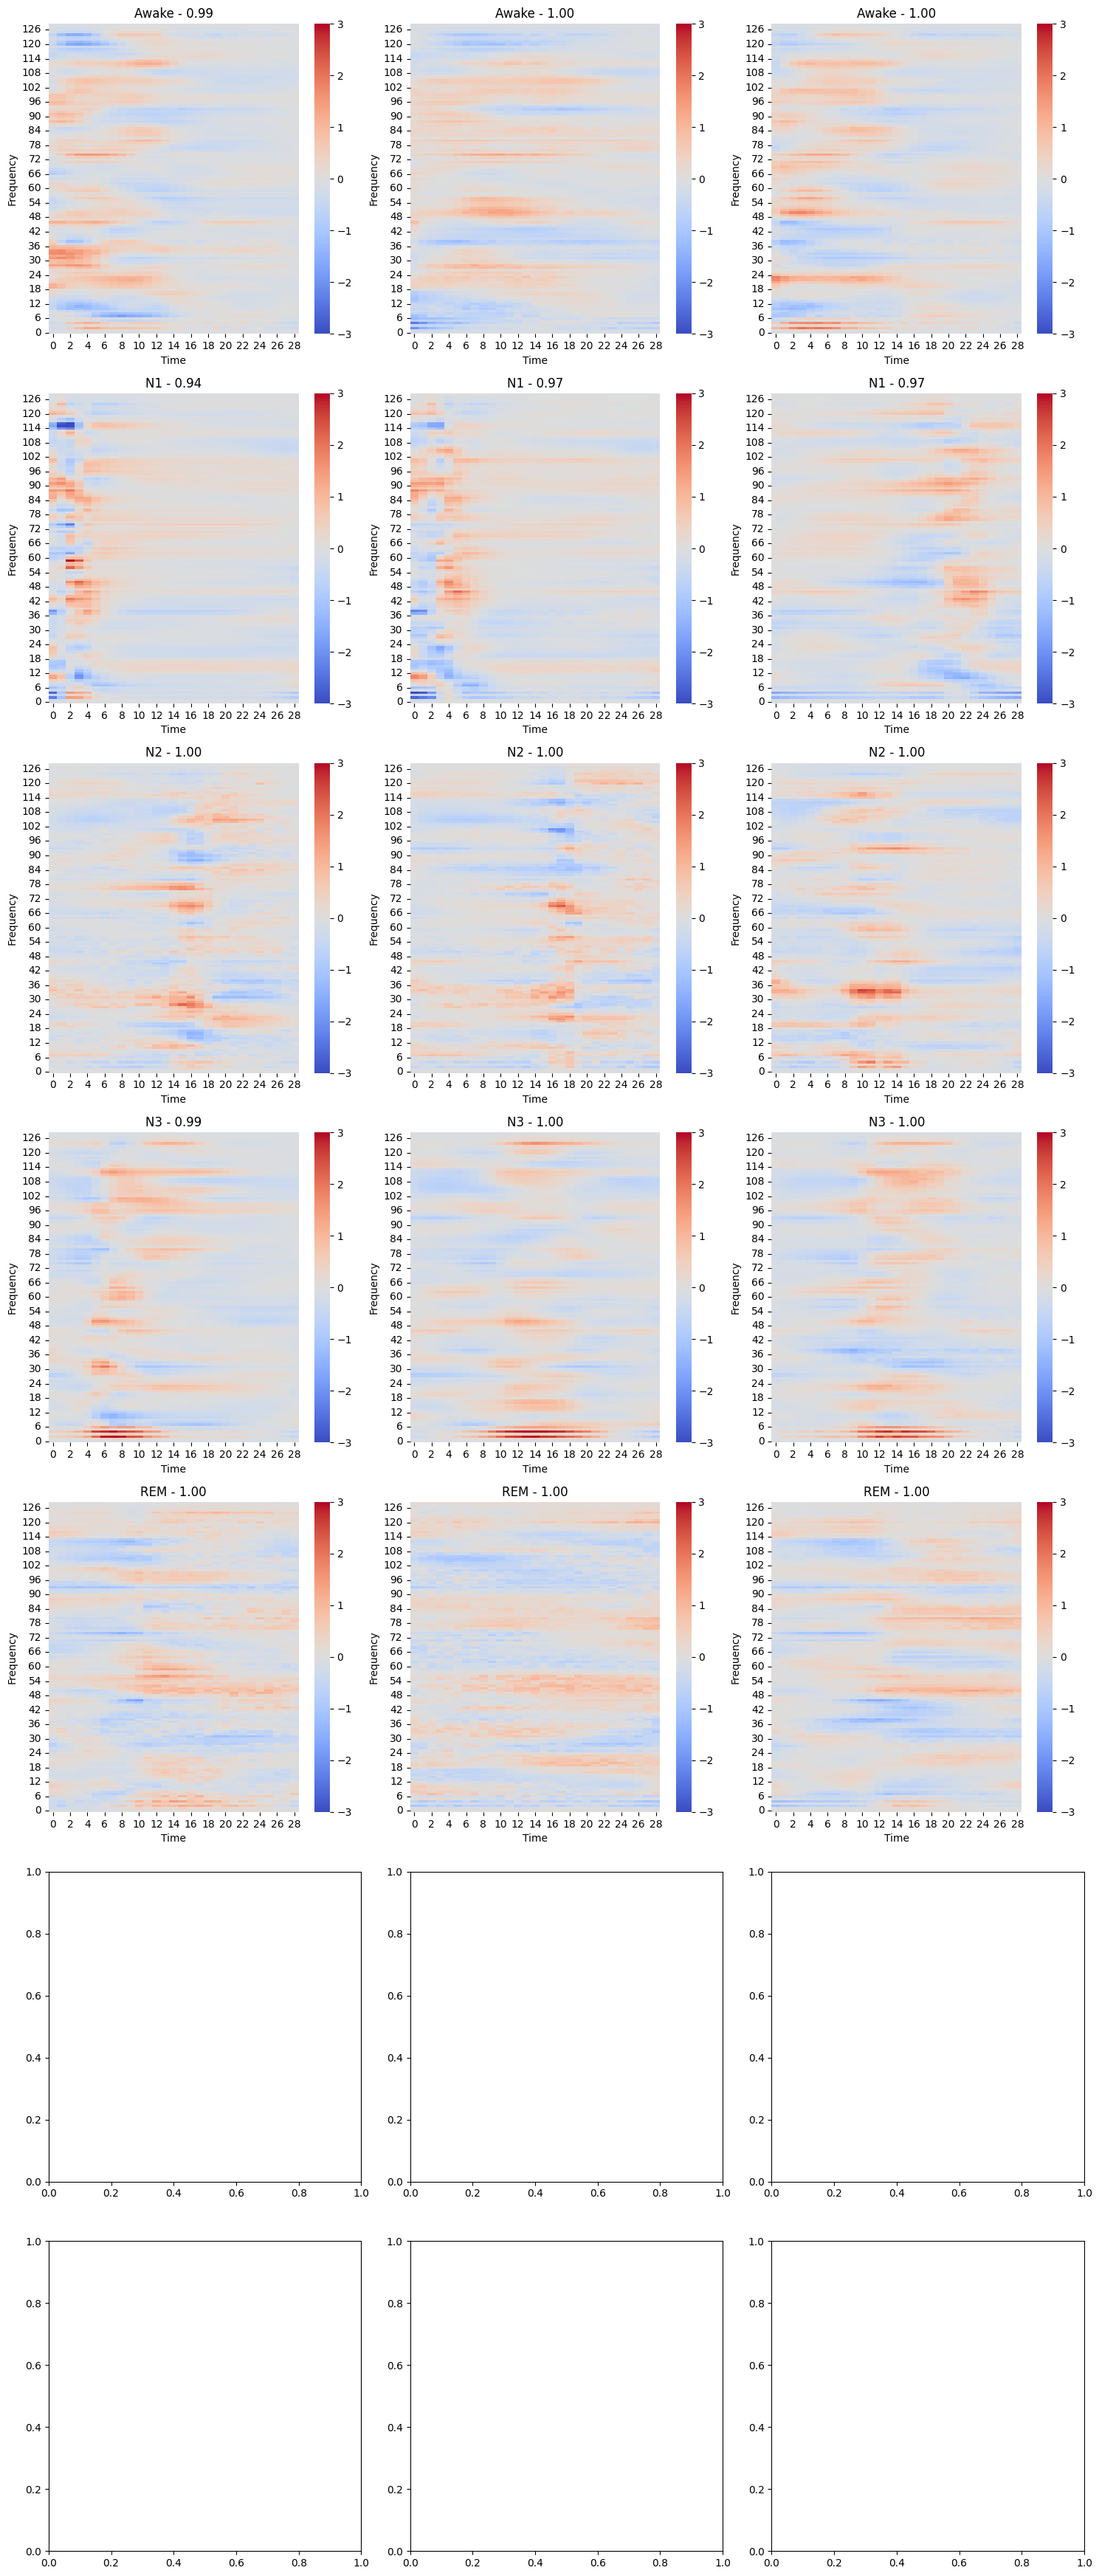

In [47]:
plotSpectrograms20(proto_rec, proto_class_list, max, min)

/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram_tensor, dtype=torch.double)
/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram_tensor, dtype=torch.double)
/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram_tensor, dtype=torch.double)
/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy

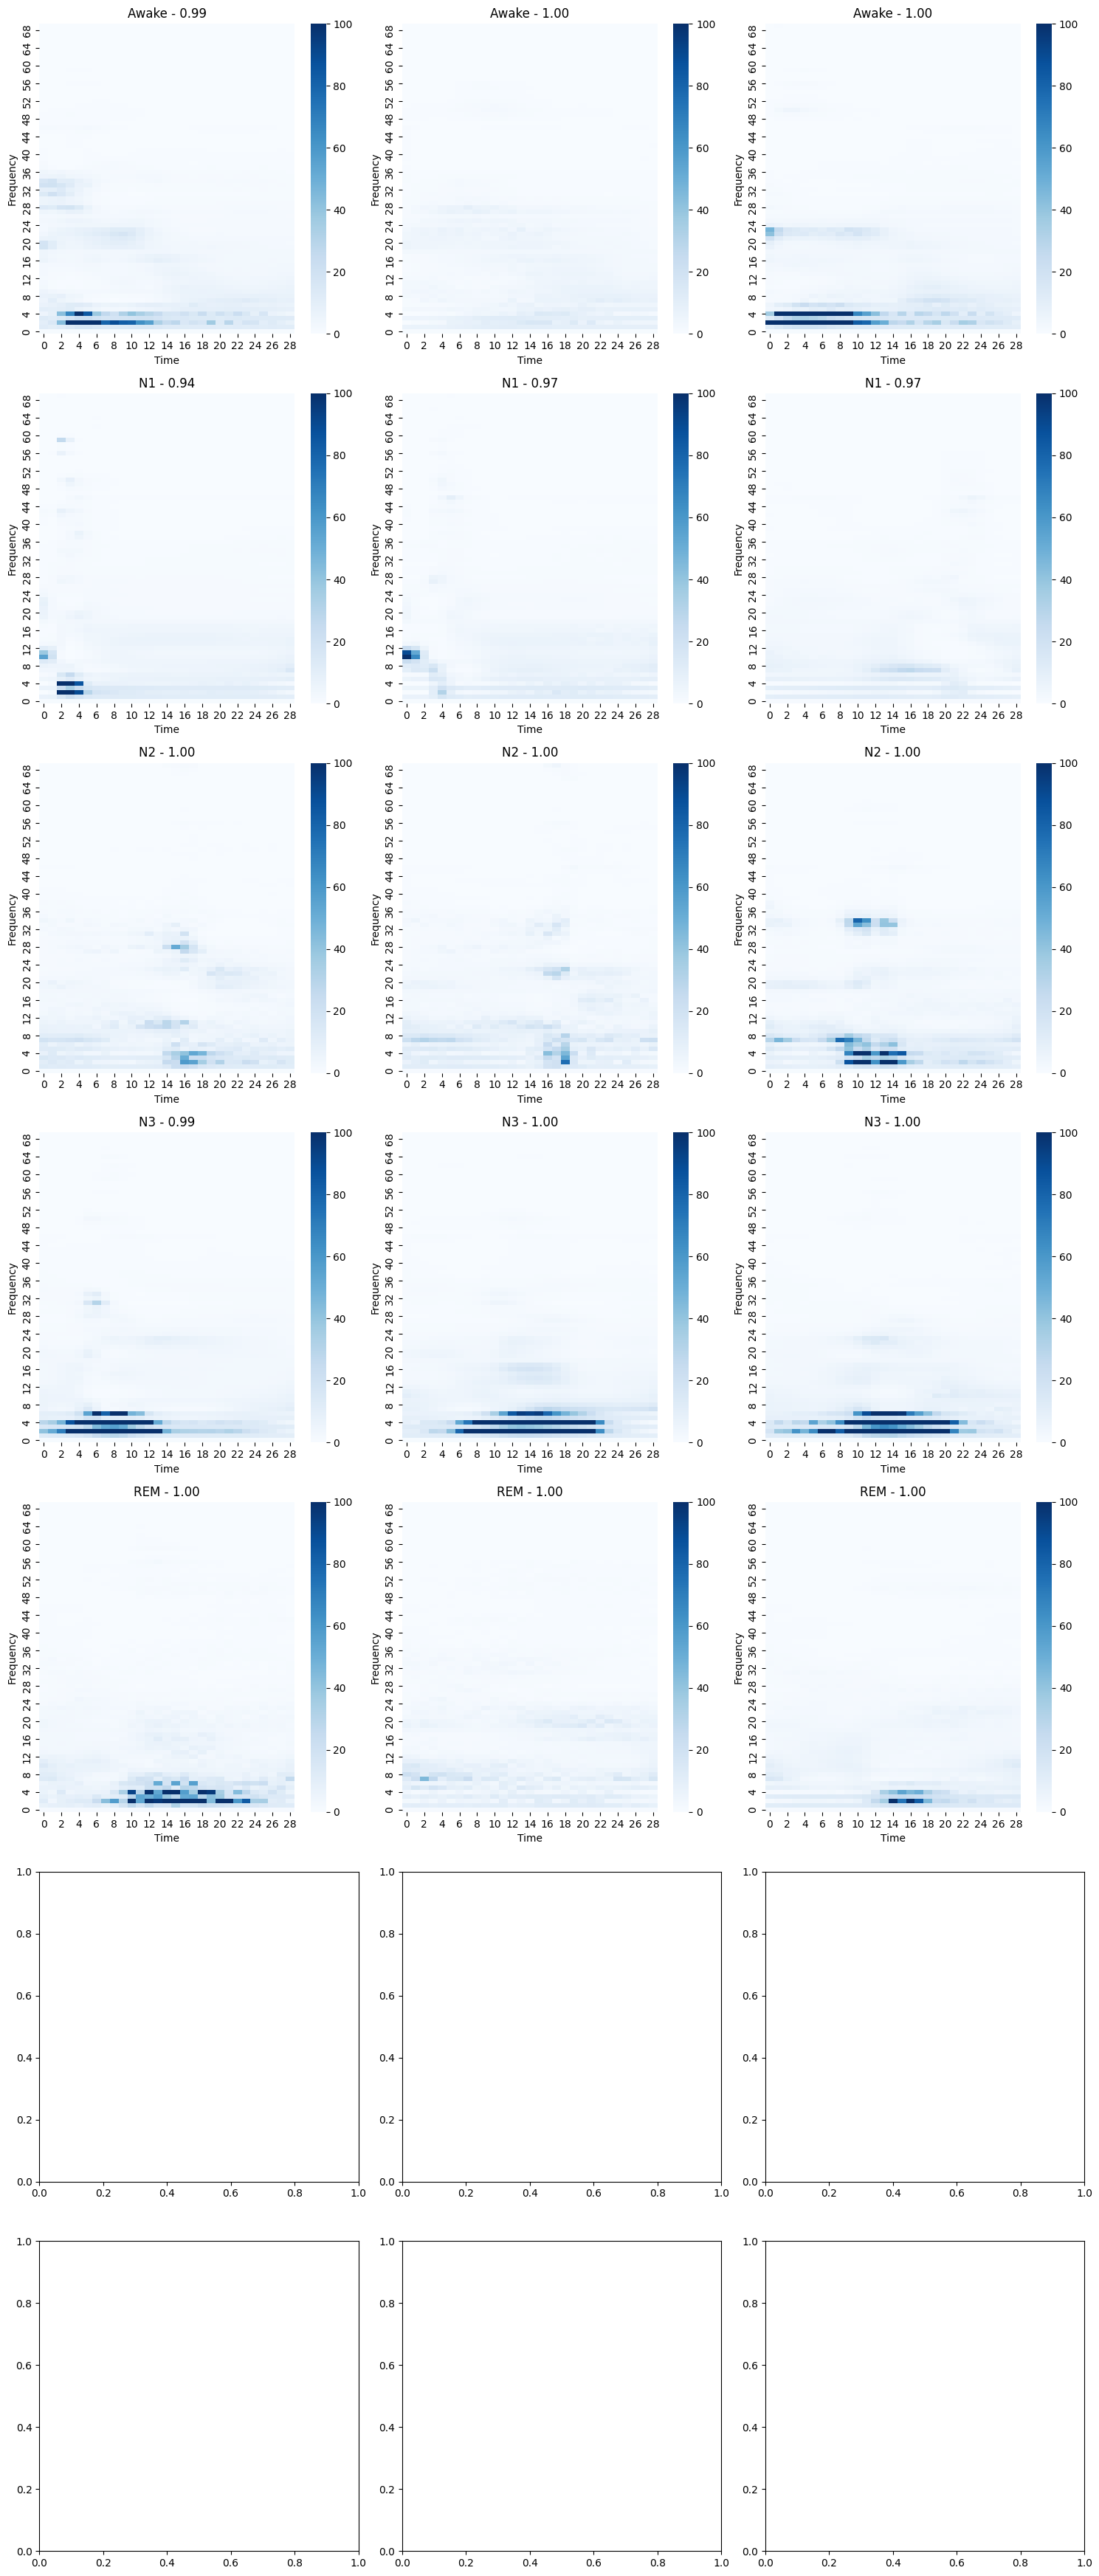

In [51]:
plotSpectrograms20(proto_rec, proto_class_list, 100, 0, denorm=(scaling_mean, scaling_std), cut=70)

## Inputs selection to rapresent Prototypes 

In [25]:
# compute the metrics on the test set
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
#dataloder = dataset.test_dataloader()
dataloder = dataset.test_dataloader()
#num = len(dataloder)*batch_size
emb_dim = 128

model = model1

In [26]:
L = model.nn.L
central_epoch = int((L - 1) / 2)
print("L: ", L, "\tcentral_epoch: ", central_epoch)

raw_prototypes = model.nn.prototypes
proto_to_emb = torch.unsqueeze(raw_prototypes, 1).repeat(1, 3, 1, 1, 1)
proto_emb, pred = model.nn.wrapped_model.encode(proto_to_emb)
print(proto_emb.shape)
print(pred.shape)

L:  3 	central_epoch:  1
torch.Size([15, 3, 128])
torch.Size([15, 3, 5])


In [27]:
proto_emb_central = proto_emb[:, central_epoch, :].to("cpu").detach().numpy()
p=5 #how many inputs to save for each prototype

continue_var = False
input_count = 0
closest_embeddings = {i: [0]*p for i in range(proto_emb.shape[0])}
closest_distances = {i: [float('inf')]*p for i in range(proto_emb_central.shape[0])}
print(closest_distances)

closest_corresponding_inputs = {i: [0]*p for i in range(proto_emb_central.shape[0])}
closest_corresponding_labels = {i: [0]*p for i in range(proto_emb_central.shape[0])}

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        # Ottieni gli embeddings per il batch
        embeddings, pred = model.nn.wrapped_model.encode(inputs.to(device))
        embeddings = embeddings.permute(1, 0, 2)[central_epoch].cpu().detach().numpy()

        # Calcola la distanza euclidea tra prototipi ed embeddings
        for proto_index, proto in enumerate(proto_emb_central):
            distances = np.linalg.norm(embeddings - proto, axis=1)
            # Trova i p embeddings più vicini attualmente salvati per questo prototipo

            max_distance_index = np.argmax(closest_distances[proto_index])
            max_distance = closest_distances[proto_index][max_distance_index]
            # Se troviamo una distanza minore della distanza massima salvata, aggiorniamo la lista
            for idx, distance in enumerate(distances):
                if distance < max_distance:
                    # Se l'input è già stato salvato, non aggiornare
                    for j in range(p):
                        if(distance == closest_distances[proto_index][j]):
                            input_count = input_count+1
                            print("input_count: ", input_count)
                            continue_var = True
                    if continue_var:
                        continue_var = False
                        continue

                    # Sostituisci il più lontano se la distanza è più piccola
                    closest_distances[proto_index][max_distance_index] = distance
                    closest_embeddings[proto_index][max_distance_index] = embeddings[idx]
                    closest_corresponding_inputs[proto_index][max_distance_index] = inputs[idx]
                    closest_corresponding_labels[proto_index][max_distance_index] = labels[idx]
                    # Aggiorna il massimo
                    max_distance_index = np.argmax(closest_distances[proto_index])
                    max_distance = closest_distances[proto_index][max_distance_index]
                    # Print per far vedere che entrano input identici
                    # if(proto_index == 0):
                    #     print(max_distance_index, " con ", max_distance, "| new dictances: ", closest_distances[proto_index])

        if i == len(dataloder) - 1:
            n_last_batch = inputs.size(0)
    
for key in closest_embeddings:
    closest_embeddings[key] = np.array(closest_embeddings[key])

{0: [inf, inf, inf, inf, inf], 1: [inf, inf, inf, inf, inf], 2: [inf, inf, inf, inf, inf], 3: [inf, inf, inf, inf, inf], 4: [inf, inf, inf, inf, inf], 5: [inf, inf, inf, inf, inf], 6: [inf, inf, inf, inf, inf], 7: [inf, inf, inf, inf, inf], 8: [inf, inf, inf, inf, inf], 9: [inf, inf, inf, inf, inf], 10: [inf, inf, inf, inf, inf], 11: [inf, inf, inf, inf, inf], 12: [inf, inf, inf, inf, inf], 13: [inf, inf, inf, inf, inf], 14: [inf, inf, inf, inf, inf]}


100%|██████████| 84/84 [00:05<00:00, 15.42it/s]


In [28]:
input_count

0

In [29]:
closest_distances

{0: [2.3114045, 2.010841, 2.1558757, 2.1581657, 2.3041244],
 1: [2.6298802, 2.5756094, 2.3314073, 2.2775488, 2.5944214],
 2: [2.0565147, 1.9671651, 1.925236, 1.8894773, 1.8635397],
 3: [2.1778843, 2.1067076, 2.1381884, 2.1062737, 2.1842456],
 4: [2.1629784, 2.1191041, 2.3567436, 2.340736, 2.350348],
 5: [3.1749163, 3.147713, 3.0894113, 3.21899, 3.0393236],
 6: [2.2781413, 2.311479, 2.2314136, 2.3063254, 2.3681633],
 7: [2.0085056, 2.0264351, 1.9318247, 1.8115445, 1.9249609],
 8: [1.9792978, 1.9091053, 1.9331346, 1.9295285, 1.8415121],
 9: [1.2902689, 1.2012463, 1.2250391, 1.1697787, 1.3508306],
 10: [2.6722875, 2.7731311, 2.781347, 2.8314888, 2.5609758],
 11: [2.156704, 2.113242, 2.1198647, 2.0422018, 2.0566897],
 12: [1.6268308, 1.6430193, 1.5908581, 1.6844523, 1.5229506],
 13: [2.8661969, 2.8942585, 2.5766299, 2.8811076, 2.914914],
 14: [1.4948434, 1.4707778, 1.3578767, 1.5064213, 1.2423398]}

In [30]:
for idx in closest_corresponding_labels:
    print(idx, closest_corresponding_labels[idx])

0 [tensor([0, 1, 1]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 1, 1]), tensor([0, 0, 1])]
1 [tensor([0, 0, 0]), tensor([1, 1, 2]), tensor([1, 2, 2]), tensor([0, 1, 2]), tensor([0, 1, 2])]
2 [tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2])]
3 [tensor([3, 3, 3]), tensor([3, 3, 3]), tensor([3, 3, 3]), tensor([3, 3, 3]), tensor([3, 3, 3])]
4 [tensor([4, 4, 4]), tensor([4, 4, 4]), tensor([1, 4, 4]), tensor([4, 4, 4]), tensor([4, 4, 4])]
5 [tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([2, 1, 2]), tensor([0, 0, 0])]
6 [tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([4, 4, 2]), tensor([2, 2, 2])]
7 [tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2])]
8 [tensor([3, 3, 3]), tensor([3, 3, 3]), tensor([3, 3, 3]), tensor([3, 3, 3]), tensor([3, 3, 3])]
9 [tensor([4, 4, 4]), tensor([4, 4, 4]), tensor([4, 4, 4]), tensor([4, 4, 4]), tensor([4, 4, 4])]
10 [tensor([0, 0, 0]

In [31]:
closest_corresponding_inputs[0][0][central_epoch][0].shape

torch.Size([29, 129])

In [32]:
closest_corresponding_inputs[0][0][central_epoch][0].shape #[x prototipi][p sequenze][l epoche][n canali]

torch.Size([29, 129])

/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram_tensor, dtype=torch.double)
/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram_tensor, dtype=torch.double)
/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram_tensor, dtype=torch.double)
/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy

/tmp/ipykernel_2510958/1503587899.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram_tensor, dtype=torch.double)


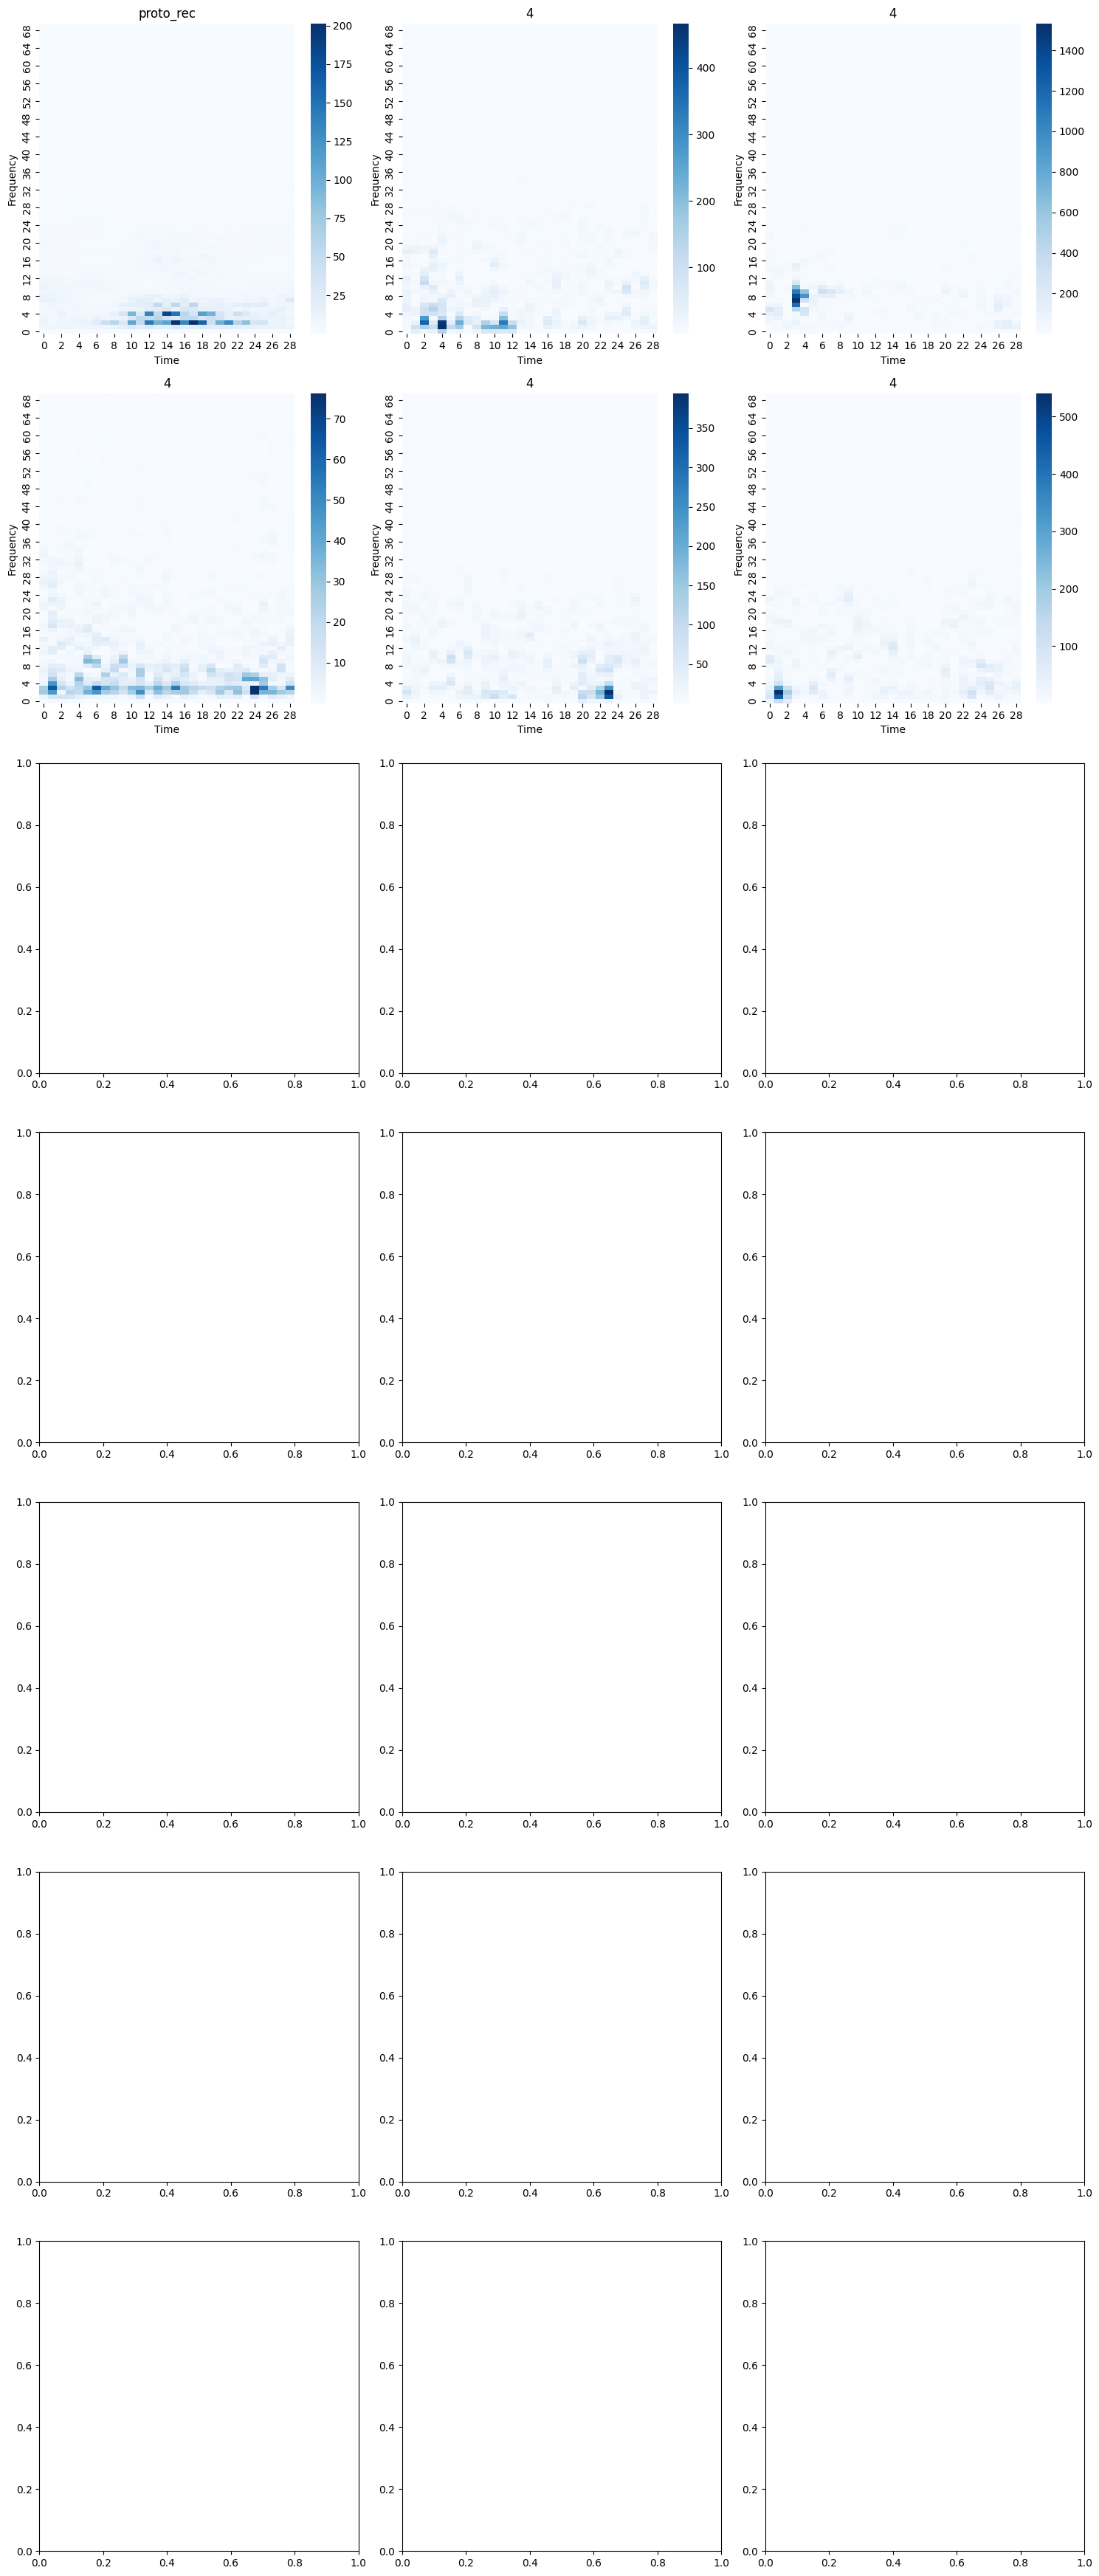

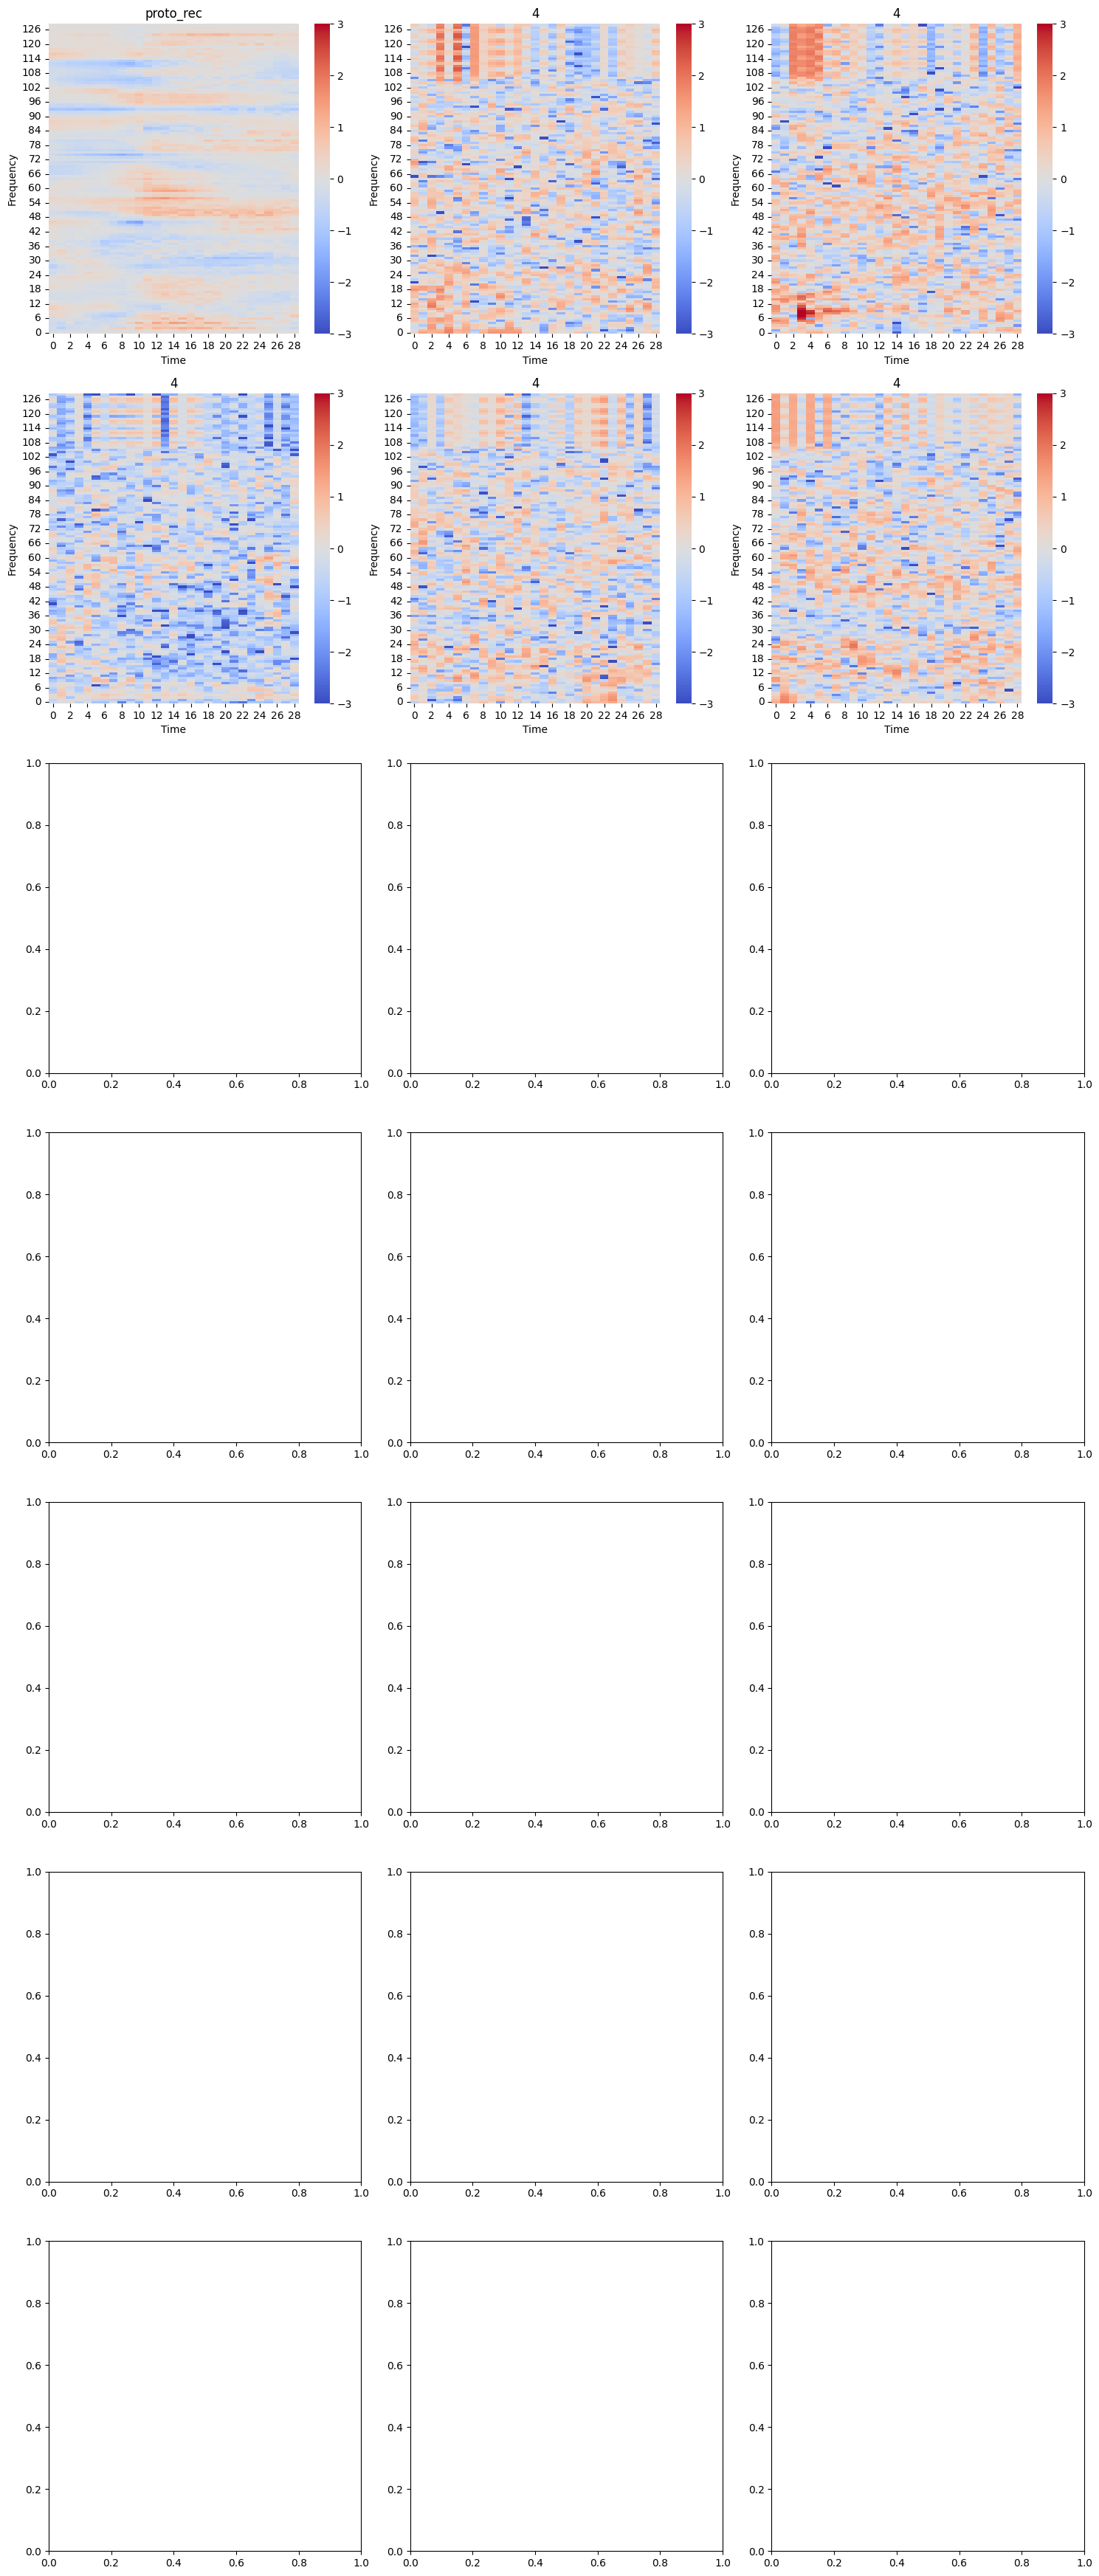

In [50]:
proto_idx_to_print = 4

labels_to_print_central = []
proto_to_print_central = []

for i in range(p):
    #proto_to_print_central.append(closest_corresponding_inputs[proto_idx_to_print][i][central_epoch-1][0])
    proto_to_print_central.append(closest_corresponding_inputs[proto_idx_to_print][i][central_epoch][0])
    #proto_to_print_central.append(closest_corresponding_inputs[proto_idx_to_print][i][central_epoch+1][0])
    #labels_to_print_central.append(str(closest_corresponding_labels[proto_idx_to_print][i][central_epoch-1].item()))
    labels_to_print_central.append(str(closest_corresponding_labels[proto_idx_to_print][i][central_epoch].item()))
    #labels_to_print_central.append(str(closest_corresponding_labels[proto_idx_to_print][i][central_epoch+1].item()))

plotSpectrograms20([raw_prototypes[proto_idx_to_print][0].cpu().detach()] + proto_to_print_central, ["proto_rec"] + labels_to_print_central, None, None, denorm=(scaling_mean, scaling_std), cut=70)
plotSpectrograms20([raw_prototypes[proto_idx_to_print][0].cpu().detach()] + proto_to_print_central, ["proto_rec"] + labels_to_print_central, max, min)

In [50]:
torch.mean(torch.std(inputs, dim= (-2, -1)))

tensor(0.8852)

In [51]:
torch.mean(torch.std(inputs, dim=(-2)))

tensor(0.8143)

In [52]:
torch.mean(torch.std(inputs, dim=(-1)))

tensor(0.8319)

## Visualize Embeddings

In [171]:
dataloder = dataset.test_dataloader()
model = model1

In [172]:
num = len(dataloder)*batch_size
emb_dim = 128


prototypes = model.nn.prototypes.cpu().detach().numpy()

sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
raw_prototypes = model.nn.prototypes

proto_to_emb = torch.unsqueeze(raw_prototypes, 1).repeat(1, 3, 1, 1, 1)
proto_emb, pred = model.nn.wrapped_model.encode(proto_to_emb)
proto_emb = proto_emb.permute(1, 0, 2)[central_epoch].cpu().detach().numpy()

print(proto_emb.shape)
print(pred.shape)

L = model.nn.L
central_epoch = int((L - 1) / 2)
print("L: ", L, "\tcentral_epoch: ", central_epoch)

(15, 128)
torch.Size([15, 3, 5])
L:  3 	central_epoch:  1


In [173]:
embeddings_array = np.empty((num, emb_dim))
labels_array = np.empty((num))

print(embeddings_array.shape)
print(labels_array.shape)

prototypes.shape
count = 0
correct = 0
with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        #print(sleep_stages[labels[batch].item()])

        embedding, pred = model.nn.wrapped_model.encode(inputs.to(device))
        embedding = embedding.permute(1, 0, 2)
        embeddings_array[i*batch_size : i*batch_size+inputs.size(0)] = embedding[central_epoch].cpu().numpy()
        labels_array[i*batch_size : i*batch_size+inputs.size(0)] = labels[:, central_epoch].cpu().numpy()

        # pred = model.nn.classify(model.nn.encode(inputs.to(device))).argmax(dim=1)
        # count = count + torch.sum(pred == 1)
        # correct += (pred == labels[:, epoch_to_save]).sum().item()

        if i == len(dataloder)-1:
            n_last_batch = inputs.size(0)

        #for shhs dataset
        if i == 1200:
            break


print(count)
print(correct)

(10752, 128)
(10752,)


  0%|          | 0/84 [00:00<?, ?it/s]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


100%|██████████| 84/84 [00:25<00:00,  3.31it/s]

0
0


In [174]:
#last significant element
embeddings_array[len(embeddings_array)-batch_size+n_last_batch - 1]

array([-0.42636541,  0.69919622, -0.51653677, -0.30752078, -0.97234106,
        0.84502524,  0.39760119,  0.31111696, -0.51511711,  0.4804368 ,
       -0.74015307,  0.35153493,  0.28354055,  0.16324802, -0.83524746,
        0.54485315, -0.23712291, -0.77460176, -0.7784279 , -0.93457258,
       -0.95384866,  0.91327316,  0.89710355, -0.66102833, -0.88779062,
        0.32533756,  0.73208773,  0.19516706, -0.20560144,  0.97393441,
        0.21814232, -0.80566424, -0.51269889,  0.35795683,  0.18346977,
        0.89729828,  0.54881132,  0.53486639, -0.40103737, -0.91757166,
        0.43431857,  0.15153623,  0.35921741, -0.80966675, -0.99535465,
        0.63930386,  0.2135507 , -0.02452274, -0.77593172, -0.39836007,
        0.8695218 , -0.4265646 ,  0.62458336,  0.34362331,  0.07992839,
       -0.88519055,  0.47144681, -0.67148864,  0.65085852, -0.54203278,
        0.19154866, -0.95960057, -0.61530554,  0.79892844, -0.49290431,
        0.08303719,  0.89954907, -0.61067718,  0.6923539 , -0.51

In [175]:
embeddings_array[len(embeddings_array)-batch_size+n_last_batch]

array([        nan, -0.69006245, -0.54427978, -0.73089932, -0.05910738,
        0.37936714,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [176]:
first_empty_element = len(embeddings_array)-batch_size+n_last_batch

In [177]:
#per shhs
embeddings_array_ref = embeddings_array[0:1201*128] #edf dreem
#embeddings_array_ref = embeddings_array[0:1676032] #edf dreem mass shhs
labels_array_ref = labels_array[0:1201*128] # edf dreem

In [178]:
embeddings_array_ref = embeddings_array[0:first_empty_element] #edf dreem
#embeddings_array_ref = embeddings_array[0:1676032] #edf dreem mass shhs
labels_array_ref = labels_array[0:first_empty_element] # edf dreem
#labels_array_ref = labels_array[0:1676032] # edf dreem mass shhs

In [179]:
print("Awake:\t",np.sum(labels_array_ref == 0)/len(labels_array_ref)*100)
print("N1:\t", np.sum(labels_array_ref == 1)/len(labels_array_ref)*100)
print("N2:\t",np.sum(labels_array_ref == 2)/len(labels_array_ref)*100)
print("N3:\t",np.sum(labels_array_ref == 3)/len(labels_array_ref)*100)
print("REM:\t",np.sum(labels_array_ref == 4)/len(labels_array_ref)*100)

Awake:	 12.693383038210623
N1:	 8.061509785647717
N2:	 48.23858341099721
N3:	 10.65237651444548
REM:	 20.354147250698976


In [180]:
# Awake:	 13.404296875
# N1:	 8.421875
# N2:	 47.447265625
# N3:	 13.220052083333334
# REM:	 17.506510416666668

In [181]:
# np.save('.npy', embeddings_array_ref)
# np.save('.npy', labels_array_ref)

In [182]:
%ls

LICENSE*                             lightning_logs/
README.md*                           main.py*
__pycache__/                         mkdocs.yml*
docs/                                models/
embedding_proto15_6612_shhs.npy      multi-source-domain.yaml*
embeddings_mass_ssh_conv3d.npy       my_experiment.yaml*
embeddings_mass_ssh_seqsleepnet.npy  old_models/
example_records/                     physioex/
examples/                            physioex.egg-info/
input_to_check.pt                    requirements.txt*
label_to_check.pt                    setup.py*
labels_mass_ssh_conv3d.npy           teacher_student.py*
labels_mass_ssh_seqsleepnet.npy      teacherstudent.yaml*
labels_proto15_6612_shhs.npy         temp/


In [183]:
# embeddings_array_ref = np.load('embedding_proto15_6612_shhs.npy')
# labels_array_ref = np.load('labels_proto15_6612_shhs.npy')

In [184]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.spatial.distance import cdist



palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"])
palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"])

from matplotlib.colors import LinearSegmentedColormap
colori_personalizzati =["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"]
# Creazione della colormap
colormap_personalizzata = LinearSegmentedColormap.from_list('nome_colormap', colori_personalizzati, N=5)

def plot_pca_2d(data, colors, percentage=1, additional_points=None):
    # Perform PCA to reduce to 2 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]
    
    plt.figure(figsize=(10, 8))
    # Define a palette with 5 distinct colors
    scatter = sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=colors, palette=palette, alpha=0.6)
    #protopyes
    if additional_points is not None:
        additional_points_scaled = scaler.transform(additional_points)
        additional_points_2d = pca.transform(additional_points_scaled)
        df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
        df_additional['Cluster'] = 'Prototype'
        sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full',)
    plt.title('2D PCA of 128-dimensional data')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f} variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f} variance)')
    plt.legend(title='Color')
    plt.grid(True)
    plt.show()

def plot_pca_3d(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Plotting the results in 3D with color
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, cmap=colormap_personalizzata, alpha=0.8)
    #ax.set_title('3D PCA')
    ax.set_xlabel(f'PC 1 ({explained_variance[0]:.2f} variance)')
    ax.set_ylabel(f'PC 2 ({explained_variance[1]:.2f} variance)')
    ax.set_zlabel(f'PC 3 ({explained_variance[2]:.2f} variance)')
    #plt.colorbar(scatter, ax=ax, label='Color')
    plt.show()

def plot_pca_3d_i(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Create a DataFrame for Plotl
    df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'PC3': pca_result[:, 2],
        'Color': colors
    })
    # Plotting the results in 3D with color
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Color',
                        title='3D PCA of 32-dimensional data',
                        labels={'PC1': f'PC 1 ({explained_variance[0]:.2f} variance)',
                                'PC2': f'PC 2 ({explained_variance[1]:.2f} variance)',
                                'PC3': f'PC 3 ({explained_variance[2]:.2f} variance)'},
                        color_continuous_scale='Viridis')
    fig.update_layout(width=800,height=1000,)
    fig.update_traces(marker=dict(colorscale='Viridis'))
    fig.show()

def plot_tnse_2d(data, colors, percentage=1):
    # Applicare TSNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results_save = tsne.fit_transform(data)
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        tsne_results = tsne_results_save[random_indices]
        colors = colors[random_indices]

    

    # Visualizzare i risultati
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, cmap="viridis", marker='o')
    plt.colorbar(ticks=range(5))
    plt.clim(-0.5, 2.5)
    plt.xlabel('TSNE component 1')
    plt.ylabel('TSNE component 2')
    plt.title('t-SNE visualization of Iris dataset')
    plt.show()

def plot_parcord(data, colors, percentage=1, eps = 0.00001):
    
    if (percentage<1):
            num_elements = int(len(data) * percentage)
            random_indices = np.random.choice(len(data), num_elements, replace=False)

            # Create new sampled arrays
            data = embeddings_array_ref[random_indices]
            colors = colors[random_indices]

    df = pd.DataFrame(data[:,:])
    df['phase'] = colors
    df.iloc[0, 32] = 0
    df.iloc[1, 32] = 1
    df.iloc[2, 32] = 2
    df.iloc[3, 32] = 3
    df.iloc[4, 32] = 4
    # Creare il Parallel Coordinates Plot
    for i in range(32):
        if (df[i].max() - df[i].min()) < eps:
            print("Non used feature: ", i)
            
    plt.figure(figsize=(10, 6))
    parallel_coordinates(df, 'phase', colormap=colormap_personalizzata)
    #parallel_coordinates(df, df[0])
    plt.title('Parallel Coordinates')
    plt.xlabel('Features')
    plt.ylabel('Value')
    plt.show()

def plot_silhouette_scores(data, n_clusters_range, percentage=1):
    silhouette_avgs = []
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        data = data[random_indices]

    for n_clusters in n_clusters_range:
        # Eseguire il clustering con K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        # Calcolare l'indice di silhouette medio
        if len(set(cluster_labels)) > 1:  # Assicurati che ci siano almeno due cluster
            silhouette_avg = silhouette_score(data, cluster_labels)
        else:
            silhouette_avg = -1  # Se c'è solo un cluster, silhouette score non è definito
        
        silhouette_avgs.append(silhouette_avg)
        print(f"Silhouette n={n_clusters} - {round(silhouette_avg, 3)}\\\\")

    # Creare il grafico
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=n_clusters_range, y=silhouette_avgs, marker='o')
    plt.title('Average Silhouette Score for Different Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.grid(True)
    plt.show()
    
def plot_KMeans_with_PCA(data, n_clusters, additional_points=None):
    # Eseguire il clustering con K-means
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    
    # Ridurre la dimensionalità a 2D per la visualizzazione usando PCA
    pca_comp = 2
    pca = PCA(n_components=pca_comp)
    data_2d = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    for i in range(pca_comp):
        print(f"Explained variance by component {i+1}: {explained_variance[i]:.2f}")   
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels

    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab20', s=50, marker='o', legend='full')
    #protopyes
    if additional_points is not None:
        additional_points_scaled = scaler.transform(additional_points)
        additional_points_2d = pca.transform(additional_points_scaled)
        df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
        df_additional['Cluster'] = 'Prototype'
        sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full',)

    plt.title(f'Cluster K-means (n_clusters = {n_clusters}) - PCA Projection')
    plt.xlabel(f'PC 1 ({explained_variance[0]:.2f} explained variance)')
    plt.ylabel(f'PC 2 ({explained_variance[1]:.2f} explained variance)')
    plt.legend(title='Cluster Label')
    plt.show()

def plot_clustering_with_prototypes(data, additional_points, silhouette = False):
    # Controllo se ci sono punti aggiuntivi
    if additional_points is None or len(additional_points) == 0:
        raise ValueError("I punti aggiuntivi devono essere forniti come centroidi.")

    # Standardizzare i dati
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    additional_points_scaled = scaler.transform(additional_points)
    
    # Assegnare ciascun punto al centroide più vicino
    distances = cdist(data, additional_points_scaled, metric='euclidean')
    cluster_labels = np.argmin(distances, axis=1)
    
    if silhouette:
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"Silhouette Coefficient: {silhouette_avg:.2f}")
        
    # Ridurre la dimensionalità a 2D per la visualizzazione usando PCA
    pca_comp = 2
    pca = PCA(n_components=pca_comp)
    data_2d = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    for i in range(pca_comp):
        print(f"Explained variance by component {i+1}: {explained_variance[i]:.2f}")   
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels

    # Ridurre la dimensionalità dei punti aggiuntivi
    additional_points_2d = pca.transform(additional_points_scaled)
    
    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab20', s=50, marker='o', legend='full')

    # Aggiungere i punti aggiuntivi come prototipi (centroidi)
    df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
    df_additional['Cluster'] = 'Prototype'
    sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full')
    
    plt.title('Cluster using prototypes as centroid - PCA Projection')
    plt.xlabel(f'PC 1 ({explained_variance[0]:.2f} explained variance)')
    plt.ylabel(f'PC 2 ({explained_variance[1]:.2f} explained variance)')
    plt.legend(title='Cluster Label')
    plt.show()

def plot_KMeans_with_tSNE(data, n_clusters):
    # Eseguire il clustering con K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    # Ridurre la dimensionalità a 2D per la visualizzazione usando t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data)
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['Dim1', 'Dim2'])
    df['Cluster'] = cluster_labels

    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Dim1', y='Dim2', hue='Cluster', palette='tab10', s=50, marker='o', legend='full')
    plt.title(f'Cluster K-means (n_clusters = {n_clusters}) - t-SNE Projection')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Cluster Label')
    plt.show()



In [185]:
df = pd.DataFrame(embeddings_array_ref)

Explained variance by component 1: 0.50
Explained variance by component 2: 0.22


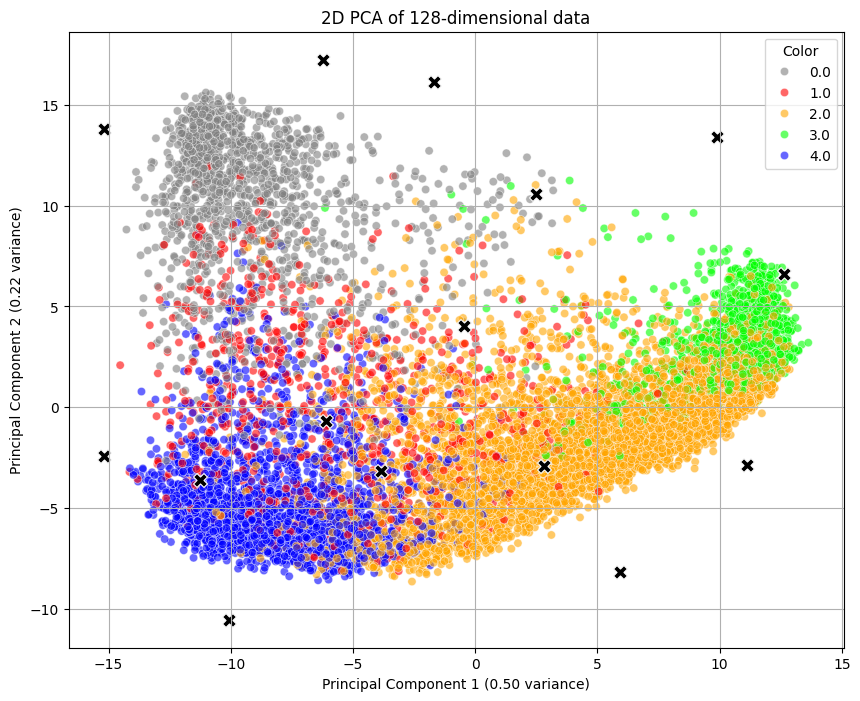

In [186]:
plot_pca_2d(embeddings_array_ref, labels_array_ref, additional_points=proto_emb, percentage=1)
#plot_pca_2d(embeddings_array_ref, labels_array_ref, percentage=0.7)

Explained variance by component 1: 0.50
Explained variance by component 2: 0.21
Explained variance by component 3: 0.10


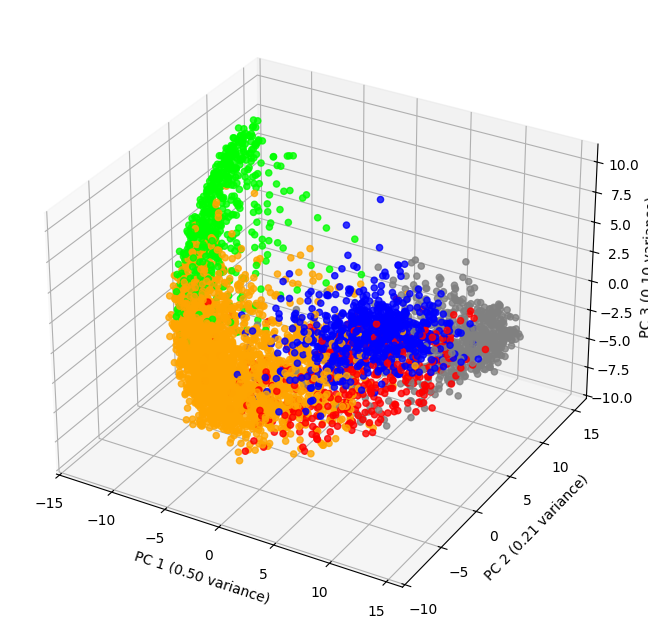

In [55]:
plot_pca_3d(embeddings_array_ref, labels_array_ref, percentage=0.1)

In [57]:
plot_pca_3d_i(embeddings_array_ref, labels_array_ref, percentage=0.5)

Explained variance by component 1: 0.50
Explained variance by component 2: 0.21
Explained variance by component 3: 0.10


Explained variance by component 1: 0.50
Explained variance by component 2: 0.22


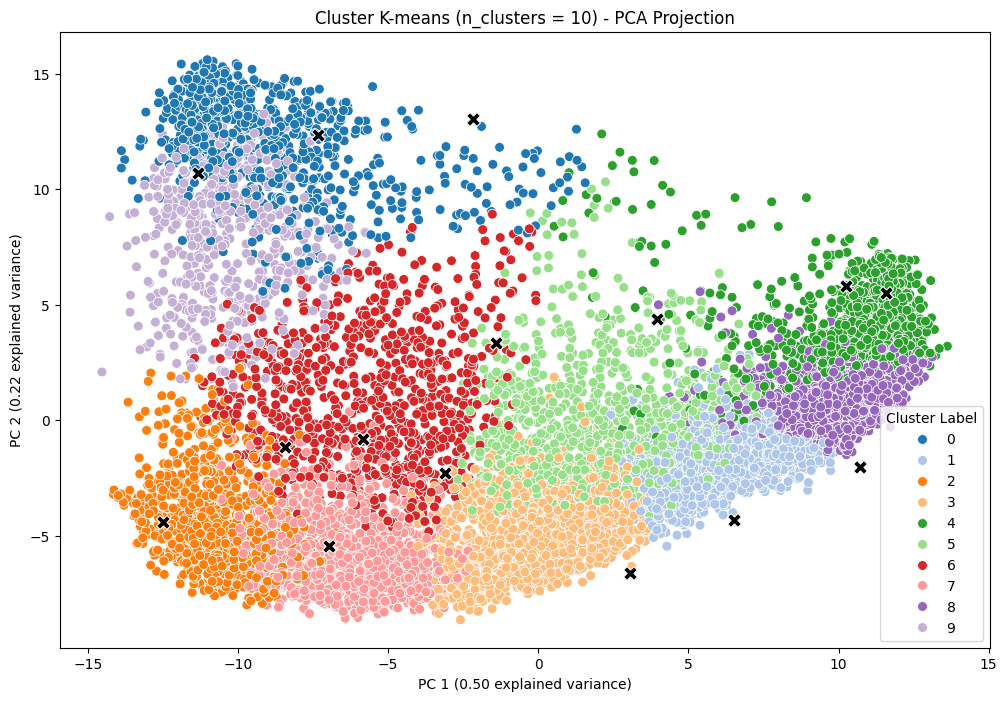

In [94]:
plot_KMeans_with_PCA(embeddings_array_ref, 10, proto_emb)

Silhouette Coefficient: 0.07
Explained variance by component 1: 0.50
Explained variance by component 2: 0.22


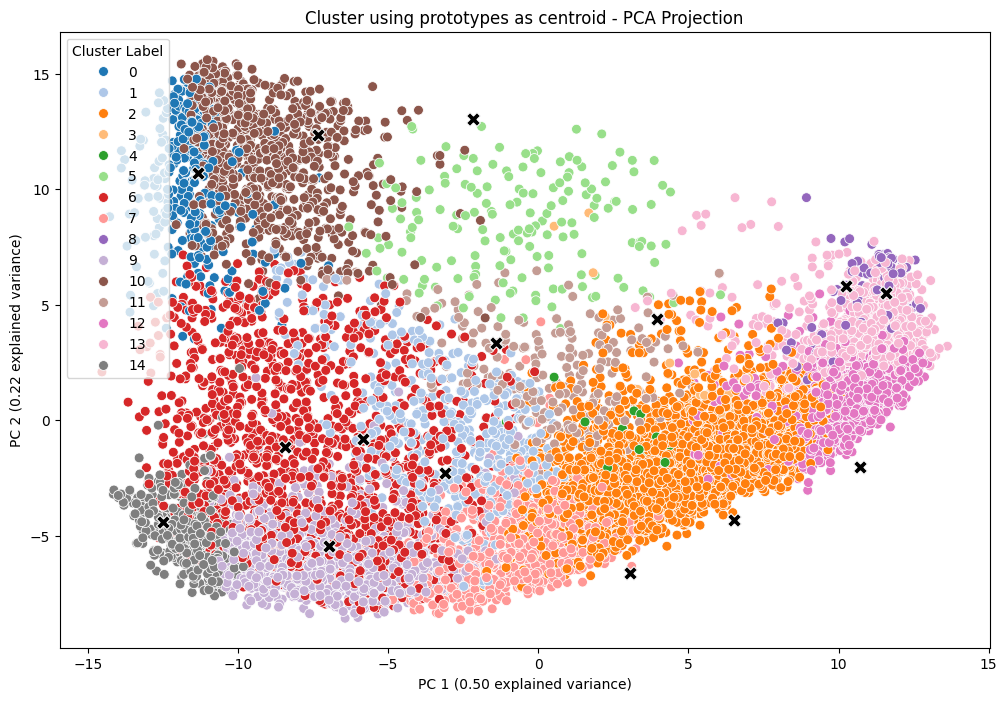

In [95]:
plot_clustering_with_prototypes(embeddings_array_ref, proto_emb, silhouette=True)

In [36]:
#plot_KMeans_with_tSNE(embeddings_array_ref, 9)

Silhouette n=10 - 0.183\\


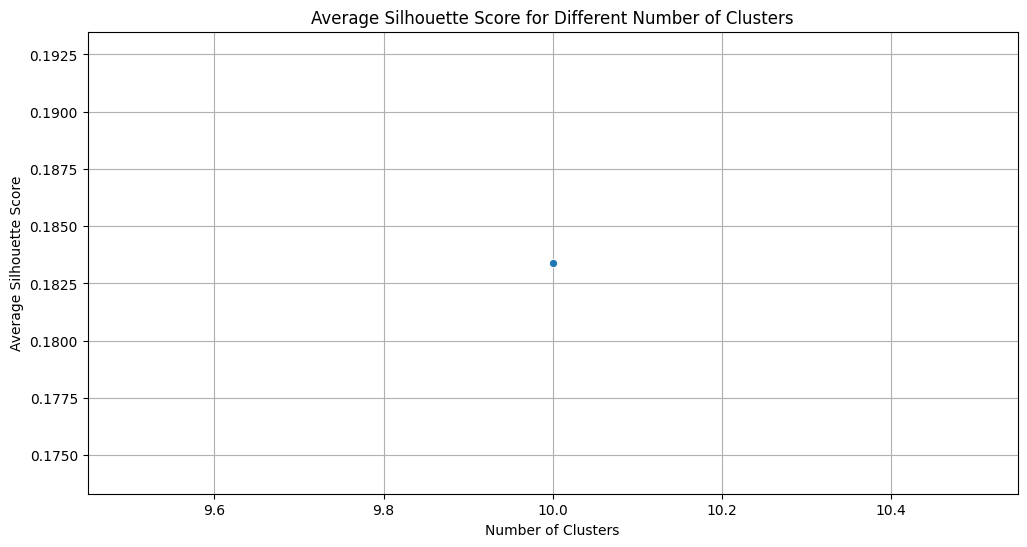

In [96]:
plot_silhouette_scores(embeddings_array_ref, range(10, 11), percentage=1)

In [ ]:
plot_parcord(embeddings_array_ref, labels_array_ref, percentage=0.1, eps = 0.01)

In [ ]:
from pandas.plotting import parallel_coordinates

data = embeddings_array_ref
colors = labels_array_ref
percentage = 0.05

# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(data)

if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        data = embeddings_array_ref[random_indices]
        colors = colors[random_indices]

df = pd.DataFrame(data[:,:])
df['phase'] = colors

# Creare il Parallel Coordinates Plot
plt.figure(figsize=(10, 6))
parallel_coordinates(df, 'phase', colormap='viridis')
plt.title('Parallel Coordinates')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

## Plotting the validation loss

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_from_csv(files, label, metric='val_loss'):
    colors = ['g', 'b', 'r']  # Define colors for the plots
    rainbow_colors = [
    "#FF0000",  # Rosso
    "#FF7F00",  # Arancione
    'g', #"#00FF00",  # Verde
    #"#FFFF00",  # Giallo
    "#0000FF",  # Blu
    "#4B0082",  # Indigo
    "#8B00FF",   # Viola
        
]   
    for i, file in enumerate(files):
        # Read the CSV file
        df = pd.read_csv(file)
        df = df.dropna(subset=[metric])
        # Extract 'Epoch' and 'Val_loss' columns
        epochs = df['step']/(df['step'].max()/df['epoch'].max())
        val_loss = df[metric]
        
        # Handle missing values by interpolating
        #val_loss = val_loss.interpolate()
        
        # Plot the values
        plt.plot(epochs, val_loss, color=rainbow_colors[i], label=label[i])

    # Add labels and title
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.legend()
    #plt.grid(True)
    plt.show()

In [ ]:
# List of CSV files
files = [
    'models/ae_seq3_freq_importance_da_mettere_in_tesi/ae_seq_weighted_1.0_1.0/version_0/metrics.csv',
    'models/ae_seq3_freq_importance_da_mettere_in_tesi/ae_seq_weighted_1.5_0.5/version_0/metrics.csv',
    'models/ae_seq3_freq_importance_da_mettere_in_tesi/ae_seq_weighted_1.9_0.1/version_0/metrics.csv',
    'models/ae_seq3_freq_importance_da_mettere_in_tesi/ae_seq_weighted_1.95_0.05/version_0/metrics.csv',
]
#legend = ['phi1=1.0, phi2=1.0','phi1=1.8, phi2=0.2', 'phi1=1.9, phi2=0.1']
legend  = ['ae_seq','ae_seq g=(1.5,0.5)', 'ae_seq g=(1.9,0.1)', 'ae_seq g=(1.95,0.05)']
# Call the function to plot the data
plot_from_csv(files, legend, metric='val_mse')

In [ ]:
plot_from_csv(files, legend, metric='val_mse_first_freq')

In [ ]:
plot_from_csv(files, legend, metric='val_mse_last_freq')

In [ ]:
plot_from_csv(files, legend, metric='val_std_penalty_T')

In [ ]:
plot_from_csv(files, legend, metric='val_std_penalty_F')

## Proto Loss Visualization

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_csv(file, metrics, ylimit=1.5):
    rainbow_colors = [
    "#FF0000",  # Rosso
    "#FF7F00",  # Arancione
    'g', #"#00FF00",  # Verde
    "#FFFF00",  # Giallo
    "#0000FF",  # Blu
    "#4B0082",  # Indigo
    "#8B00FF",   # Viola
    ""
    ]
    colors = [
    "r",  # Tomato (Rosso pomodoro)
    "#40E0D0",  # Turquoise (Turchese)
    "#66FF00", # BrightGreen (Verde brillante)
    "#FFD700",  # Gold (Oro)
    "#8A2BE2",  # BlueViolet (Blu violetto)
    "gray",  # OrangeRed (Arancione rosso)
    "#2E8B57",  # SeaGreen (Verde mare)
    "#DAA520",  # GoldenRod (Rododendro dorato)
    "b",  # DarkTurquoise (Turchese scuro)
    "#FF1493"   # DeepPink (Rosa intenso)
    ]   
    df = pd.read_csv(file)
    plt.figure(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        df = df.dropna(subset=[metric])
        # Extract 'Epoch' and 'Val_loss' columns
        epochs = df['step']/(df['step'].max()/df['epoch'].max())
        metric_ = df[metric]
        
        # Handle missing values by interpolating
        #val_loss = val_loss.interpolate()
        
        # Plot the values
        plt.plot(epochs, metric_, color=colors[i], label=metrics[i])

    # Add labels and title
    plt.xlabel('epoch')
    #plt.ylabel('')
    plt.ylim(0, ylimit)
    plt.legend(loc='lower left')
    #plt.grid(True)
    plt.show()
    

In [ ]:
metrics = ['val_cel', 'val_f1','val_mf1', 'val_mse', 'val_r1', 'val_r2', 'val_reconstr_loss',
           'val_std_pen', 'val_std_pen_F', 'val_std_pen_T']
file = 'models/protoae_seqsleepnet/protoae_ssn6611.5_shhs_l3_eeg/lightning_logs/version_0/metrics.csv'
plot_model_csv(file, metrics, 1)